In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

In [2]:
df = pd.read_csv("./kieranFeatures_1-30_14-Nov-2024_rawSA.csv").replace([np.inf, -np.inf], np.nan).interpolate() # Perform linear interpolation on all non-valid numbers

df["Lv_1_Hi"] = (df["SA1"] >= 5).astype(int)
df["Lv_2_Hi"] = (df["SA2"] >= 5).astype(int)
df["Lv_3_Hi"] = (df["SA3"] >= 5).astype(int)
df["Tot_Hi"] = (df["SAtotal"] >= 15).astype(int)

ids = df.iloc[:, 0]
trial_nums = df.iloc[:, 1]
predictors_df = df.iloc[:, 2:df.shape[1] - 8]
outcomes_df = df.iloc[:, df.shape[1] - 8:]

# Shuffle Labels
outcomes_df["Lv_1_Hi"] = np.random.permutation(outcomes_df["Lv_1_Hi"])
outcomes_df["Lv_2_Hi"] = np.random.permutation(outcomes_df["Lv_2_Hi"])
outcomes_df["Lv_3_Hi"] = np.random.permutation(outcomes_df["Lv_3_Hi"])
outcomes_df["Tot_Hi"] = np.random.permutation(outcomes_df["Tot_Hi"])

# Free Memory
del df

In [3]:
# Load Data
with open("./Pickle Files/raw_SA_investigation.pkl", "rb") as f:
    all_test_scores, all_CV_models, relaxed_LASSO_features = pickle.load(f)

with open("./Pickle Files/raw_SA_investigation_shuffled.pkl", "rb") as f:
    all_test_scores_shuffled, all_CV_models_shuffled, relaxed_LASSO_features_shuffled = pickle.load(f)

In [32]:
def graph_folds(test_scores, test_scores_shuffled, predictors_df, outcomes_df, outcome_var):
    width = 0.3
    x_vals = np.arange(1, 6)
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    #
    # Non-Shuffled Models
    #

    # No Penalty
    ax1.bar(x_vals - width, test_scores[outcome_var]["No Penalty"], width, label = "No Penalty")
    for i in x_vals - 1:
        ax1.text(i - width + 1, test_scores[outcome_var]["No Penalty"][i], round(test_scores[outcome_var]["No Penalty"][i], 3), ha = "center")

    # LASSO
    ax1.bar(x_vals, test_scores[outcome_var]["LASSO"], width, label = "LASSO")
    for i in x_vals - 1:
        ax1.text(i + 1, test_scores[outcome_var]["LASSO"][i], round(test_scores[outcome_var]["LASSO"][i], 3), ha = "center")

    # Modified LASSO
    ax1.bar(x_vals + width, test_scores[outcome_var]["Relaxed LASSO"], width, label = "Modified LASSO")
    for i in x_vals - 1:
        ax1.text(i + width + 1, test_scores[outcome_var]["Relaxed LASSO"][i], round(test_scores[outcome_var]["Relaxed LASSO"][i], 3), ha = "center")

    # Baselines
    ax1.axhline(y = (2 * np.sum(outcomes_df[outcome_var]) / len(outcomes_df[outcome_var])) / (np.sum(outcomes_df[outcome_var]) / len(outcomes_df[outcome_var]) + 1), color = "r", label = "Always True")
    ax1.axhline(y = 0.5, color = "orange", label = "Random Guessing")

    ax1.set_title("Actual Data")

    #
    # Shuffled Models
    #

    # No Penalty
    ax2.bar(x_vals - width, test_scores_shuffled[outcome_var]["No Penalty"], width, label = "No Penalty")
    for i in x_vals - 1:
        ax2.text(i - width + 1, test_scores_shuffled[outcome_var]["No Penalty"][i], round(test_scores_shuffled[outcome_var]["No Penalty"][i], 3), ha = "center")

    # LASSO
    ax2.bar(x_vals, test_scores_shuffled[outcome_var]["LASSO"], width, label = "LASSO")
    for i in x_vals - 1:
        ax2.text(i + 1, test_scores_shuffled[outcome_var]["LASSO"][i], round(test_scores_shuffled[outcome_var]["LASSO"][i], 3), ha = "center")

    # Modified LASSO
    ax2.bar(x_vals + width, test_scores_shuffled[outcome_var]["Relaxed LASSO"], width, label = "Modified LASSO")
    for i in x_vals - 1:
        ax2.text(i + width + 1, test_scores_shuffled[outcome_var]["Relaxed LASSO"][i], round(test_scores_shuffled[outcome_var]["Relaxed LASSO"][i], 3), ha = "center")

    # Baselines
    ax2.axhline(y = (2 * np.sum(outcomes_df[outcome_var]) / len(outcomes_df[outcome_var])) / (np.sum(outcomes_df[outcome_var]) / len(outcomes_df[outcome_var]) + 1), color = "r",  label = "Always True")
    ax2.axhline(y = 0.5, color = "orange", label = "Random Guessing")

    ax2.set_title("Shuffled Labels")

    #
    # Plot Adjustments
    #

    fig.supxlabel("Test Fold")
    fig.supylabel("F1 Score")
    fig.suptitle("F1 Score of Model Type by Test Folds for " + outcome_var)

    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc = "upper right")

    fig.tight_layout()

# SA 1

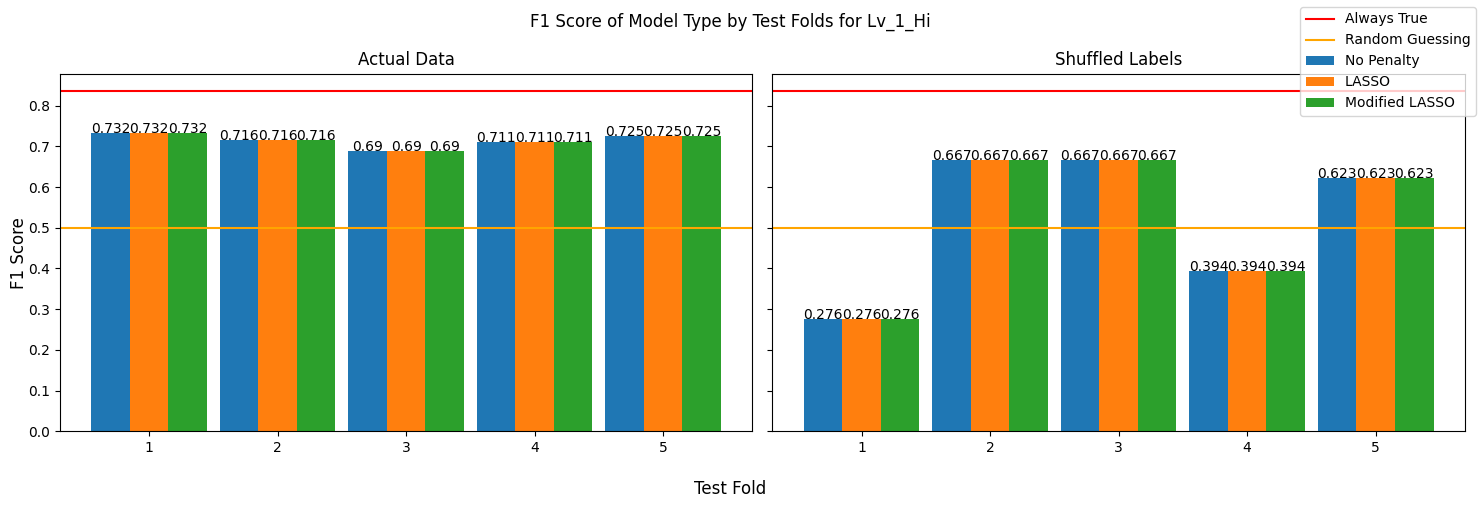

In [33]:
graph_folds(all_test_scores, all_test_scores_shuffled, predictors_df, outcomes_df, "Lv_1_Hi")

In [41]:
for i in range(5):
    print(np.sum(all_CV_models["Lv_1_Hi"]["LASSO"][i].coef_[0] != 0), np.sum(all_CV_models["Lv_1_Hi"]["Relaxed LASSO"][i].coef_[0] != 0))

print()

for i in range(5):
    print(np.sum(all_CV_models_shuffled["Lv_1_Hi"]["LASSO"][i].coef_[0] != 0), np.sum(all_CV_models_shuffled["Lv_1_Hi"]["Relaxed LASSO"][i].coef_[0] != 0))

935 107
3717 107
973 104
1146 105
1000 202

906 101
928 99
873 101
940 100
896 108


In [39]:
for i in range(5):
    print(all_CV_models["Lv_1_Hi"]["LASSO"][i].C_)

[0.001]
[0.1]
[0.001]
[0.001]
[0.001]


In [42]:
len(all_CV_models["Lv_1_Hi"]["LASSO"][i].coef_[0])

5967

# SA 2

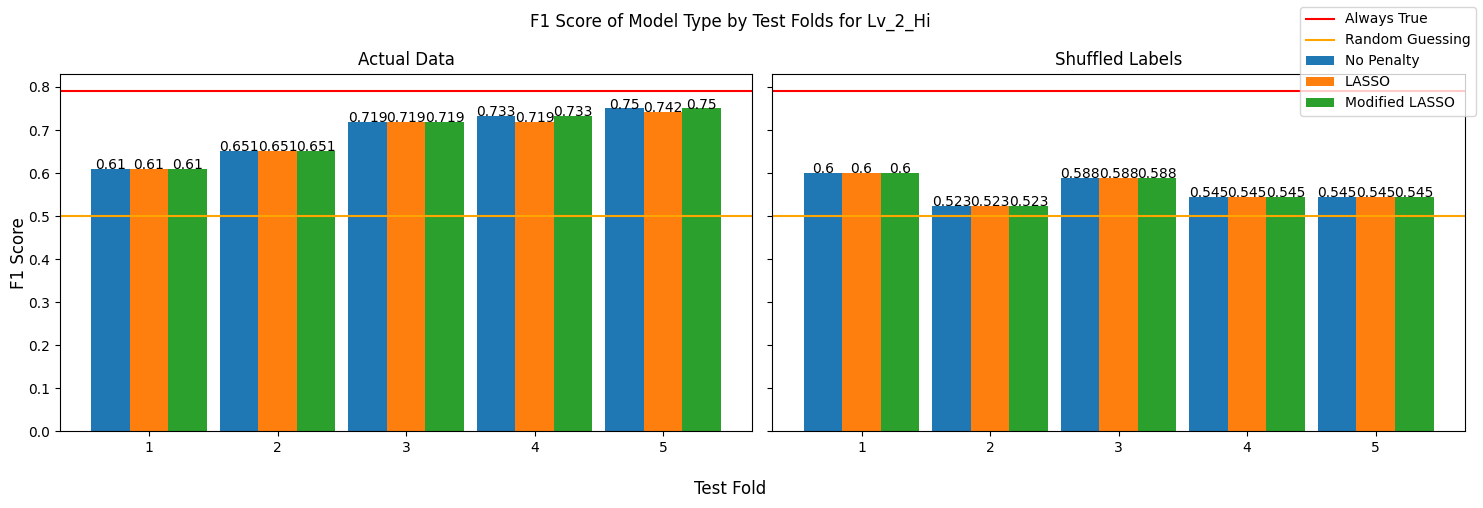

In [43]:
graph_folds(all_test_scores, all_test_scores_shuffled, predictors_df, outcomes_df, "Lv_2_Hi")